#prepare

##Import packages

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from __future__ import print_function, division
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.utils.data import Subset
from torchvision import datasets, models, transforms, utils
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageOps,ImageEnhance
import torch.nn as nn
import torch.nn.functional as F
import scipy
import torch.optim as optim

##dataset setting

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])
trainsets = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloaders = torch.utils.data.DataLoader(trainsets,
                                            batch_size=100,
                                            shuffle=True,
                                            num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=100,
                                            shuffle=False, 
                                            num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))
test_dataset_size = len(testset)

In [3]:
class CustomSubset(Subset):
    def __init__(self, dataset, indices, subset_transform=None):
        super().__init__(dataset, indices)
        self.targets = dataset.targets
        self.classes = dataset.classes
        self.subset_transform = subset_transform

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        if self.subset_transform:
            x = self.subset_transform(x)
        return x, y

    def __len__(self):
        return len(self.indices)

In [4]:
targets = trainsets.targets
train_idx, val_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    shuffle=True,
    stratify=targets
)
train_datasets = {}
train_datasets['train'] = CustomSubset(
    trainsets, train_idx)
train_datasets['val'] = CustomSubset(
    trainsets, val_idx)
dataloaders = {x: torch.utils.data.DataLoader(
    train_datasets[x], batch_size=100, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(train_datasets[x]) for x in ['train', 'val']}
class_names = trainsets.classes

##CNN

In [37]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 36, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.fc2 = nn.Linear(12*12*36, 100)
        self.fc3 = nn.Linear(100,10)
        self.softmax=nn.Softmax(dim=0)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # x = F.relu(self.conv1(x))
        x=x.view(-1,12*12*36)
        x = F.relu(self.fc2(x))
        x= self.fc3(x)
        x=self.softmax(x)
        return x

In [7]:
class SimpleCNN_AddDrop(nn.Module):
    def __init__(self):
        super(SimpleCNN_AddDrop, self).__init__()
        self.conv1 = nn.Conv2d(1, 36, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(12*12*36, 100)
        self.fc3 = nn.Linear(100,10)
        self.softmax=nn.Softmax(dim=0)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x=x.view(-1,12*12*36)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x= self.fc3(x)
        x=self.softmax(x)
        return x

##function

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # if title is not None:
    #     plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # inputs = inputs.to(device)
            # labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            with tqdm(dataloaders[phase], total=len(dataloaders[phase])) as pbar:
                # Iterate over data.
                # for inputs, labels in dataloaders[phase]:
                for inputs, labels in pbar:
                    pbar.set_description(f'[Epoch {epoch}/{num_epochs - 1}]')
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            history[f'{phase}_loss_values'].append(float(f'{epoch_loss:.4f}'))
            history[f'{phase}_accuracy_values'].append(
                float(f'{epoch_acc:4f}'))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s'
    )
    print(f'Best val Acc: {best_acc:4f}')
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [11]:
def test_model(model, optimizer):
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in testloader:
    # zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # forward
        # track history if only in train

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        labels = labels.data.cpu().numpy()
        y_pred.extend(outputs)
        y_true.extend(labels)

    test_loss = running_loss / test_dataset_size
    test_acc = running_corrects.double() / test_dataset_size
    # deep copy the model
    print()
    print(f'test_loss:{test_loss},test_acc:{test_acc}')

In [12]:
def plot_graph(values1, values2, rng, label1, label2, file_name):
    plt.figure()
    plt.plot(range(rng), values1, label=label1)
    plt.plot(range(rng), values2, label=label2)
    plt.legend()
    plt.savefig(file_name)
    plt.grid()
    # plt.show()
    plt.tight_layout()
    plt.savefig(file_name)

In [13]:
def visualize_weight():
    k=1
    for params in net.conv1.weight:
        img = transforms.ToPILImage()(params)
        plt.subplot(6,6,k)
        k+=1
        plt.imshow(img,cmap='gray')

In [14]:
def visualize_conv():
    img=train_datasets['train'][0][0].numpy()
    img=np.squeeze(img)
    k=1
    for params in net.conv1.weight:
        after_array = scipy.signal.convolve2d(img, params.detach().numpy()[0])
        plt.subplot(6,6,k)
        k+=1
        plt.imshow(after_array,cmap='gray')

#SimpleCNN lr=0.01

In [43]:
# from net import Net
net = SimpleCNN()

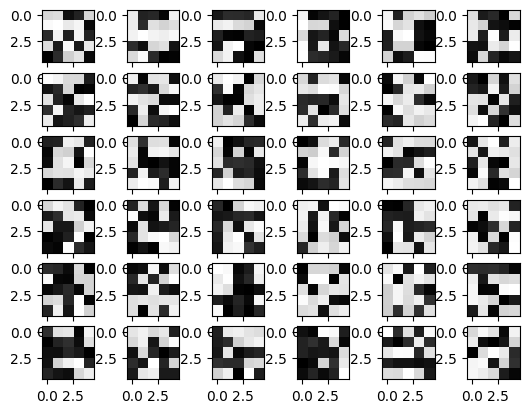

In [16]:
visualize_weight()

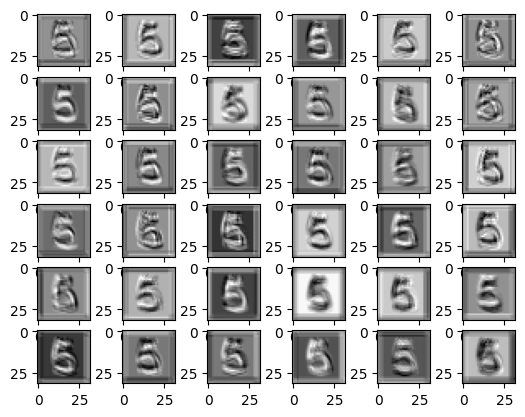

In [17]:
visualize_conv()

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.99)
scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [45]:
history = {
    'val_loss_values': [],
    'train_loss_values': [],
    'val_accuracy_values': [],
    'train_accuracy_values': []
}

model_ft, history = train_model(net, criterion, optimizer, scheduler, num_epochs=30)

Epoch 0/29
----------


[Epoch 0/29]: 100%|██████████| 480/480 [00:41<00:00, 11.61it/s]


train Loss: 2.2480 Acc: 0.6811


[Epoch 0/29]: 100%|██████████| 120/120 [00:05<00:00, 20.42it/s]


val Loss: 2.2171 Acc: 0.7833

Epoch 1/29
----------


[Epoch 1/29]: 100%|██████████| 480/480 [00:41<00:00, 11.65it/s]


train Loss: 2.2170 Acc: 0.7984


[Epoch 1/29]: 100%|██████████| 120/120 [00:05<00:00, 22.01it/s]


val Loss: 2.2166 Acc: 0.8135

Epoch 2/29
----------


[Epoch 2/29]: 100%|██████████| 480/480 [00:42<00:00, 11.42it/s]


train Loss: 2.2159 Acc: 0.8354


[Epoch 2/29]: 100%|██████████| 120/120 [00:05<00:00, 22.69it/s]


val Loss: 2.2155 Acc: 0.8429

Epoch 3/29
----------


[Epoch 3/29]: 100%|██████████| 480/480 [00:42<00:00, 11.31it/s]


train Loss: 2.2155 Acc: 0.8539


[Epoch 3/29]: 100%|██████████| 120/120 [00:05<00:00, 22.69it/s]


val Loss: 2.2152 Acc: 0.8693

Epoch 4/29
----------


[Epoch 4/29]: 100%|██████████| 480/480 [00:41<00:00, 11.58it/s]


train Loss: 2.2150 Acc: 0.8747


[Epoch 4/29]: 100%|██████████| 120/120 [00:05<00:00, 20.24it/s]


val Loss: 2.2149 Acc: 0.8825

Epoch 5/29
----------


[Epoch 5/29]: 100%|██████████| 480/480 [00:41<00:00, 11.58it/s]


train Loss: 2.2147 Acc: 0.8871


[Epoch 5/29]: 100%|██████████| 120/120 [00:05<00:00, 20.24it/s]


val Loss: 2.2146 Acc: 0.8902

Epoch 6/29
----------


[Epoch 6/29]: 100%|██████████| 480/480 [00:41<00:00, 11.55it/s]


train Loss: 2.2146 Acc: 0.8970


[Epoch 6/29]: 100%|██████████| 120/120 [00:05<00:00, 22.22it/s]


val Loss: 2.2146 Acc: 0.8985

Epoch 7/29
----------


[Epoch 7/29]: 100%|██████████| 480/480 [00:41<00:00, 11.44it/s]


train Loss: 2.2145 Acc: 0.9022


[Epoch 7/29]: 100%|██████████| 120/120 [00:05<00:00, 22.86it/s]


val Loss: 2.2145 Acc: 0.9019

Epoch 8/29
----------


[Epoch 8/29]: 100%|██████████| 480/480 [00:42<00:00, 11.38it/s]


train Loss: 2.2144 Acc: 0.9025


[Epoch 8/29]: 100%|██████████| 120/120 [00:05<00:00, 22.91it/s]


val Loss: 2.2144 Acc: 0.9041

Epoch 9/29
----------


[Epoch 9/29]: 100%|██████████| 480/480 [00:41<00:00, 11.55it/s]


train Loss: 2.2144 Acc: 0.9034


[Epoch 9/29]: 100%|██████████| 120/120 [00:05<00:00, 20.19it/s]


val Loss: 2.2144 Acc: 0.9015

Epoch 10/29
----------


[Epoch 10/29]: 100%|██████████| 480/480 [00:41<00:00, 11.62it/s]


train Loss: 2.2144 Acc: 0.9032


[Epoch 10/29]: 100%|██████████| 120/120 [00:05<00:00, 20.08it/s]


val Loss: 2.2144 Acc: 0.9025

Epoch 11/29
----------


[Epoch 11/29]: 100%|██████████| 480/480 [00:41<00:00, 11.59it/s]


train Loss: 2.2144 Acc: 0.9041


[Epoch 11/29]: 100%|██████████| 120/120 [00:05<00:00, 22.87it/s]


val Loss: 2.2144 Acc: 0.9038

Epoch 12/29
----------


[Epoch 12/29]: 100%|██████████| 480/480 [00:42<00:00, 11.38it/s]


train Loss: 2.2144 Acc: 0.9038


[Epoch 12/29]: 100%|██████████| 120/120 [00:05<00:00, 22.17it/s]


val Loss: 2.2145 Acc: 0.9026

Epoch 13/29
----------


[Epoch 13/29]: 100%|██████████| 480/480 [00:41<00:00, 11.58it/s]


train Loss: 2.2143 Acc: 0.9049


[Epoch 13/29]: 100%|██████████| 120/120 [00:05<00:00, 20.92it/s]


val Loss: 2.2143 Acc: 0.9027

Epoch 14/29
----------


[Epoch 14/29]: 100%|██████████| 480/480 [00:41<00:00, 11.66it/s]


train Loss: 2.2143 Acc: 0.9054


[Epoch 14/29]: 100%|██████████| 120/120 [00:05<00:00, 20.20it/s]


val Loss: 2.2144 Acc: 0.9037

Epoch 15/29
----------


[Epoch 15/29]: 100%|██████████| 480/480 [00:41<00:00, 11.54it/s]


train Loss: 2.2144 Acc: 0.9044


[Epoch 15/29]: 100%|██████████| 120/120 [00:05<00:00, 21.50it/s]


val Loss: 2.2144 Acc: 0.9043

Epoch 16/29
----------


[Epoch 16/29]: 100%|██████████| 480/480 [00:42<00:00, 11.30it/s]


train Loss: 2.2144 Acc: 0.9052


[Epoch 16/29]: 100%|██████████| 120/120 [00:05<00:00, 22.94it/s]


val Loss: 2.2144 Acc: 0.9061

Epoch 17/29
----------


[Epoch 17/29]: 100%|██████████| 480/480 [00:42<00:00, 11.25it/s]


train Loss: 2.2144 Acc: 0.9060


[Epoch 17/29]: 100%|██████████| 120/120 [00:05<00:00, 22.79it/s]


val Loss: 2.2145 Acc: 0.9052

Epoch 18/29
----------


[Epoch 18/29]: 100%|██████████| 480/480 [00:42<00:00, 11.29it/s]


train Loss: 2.2143 Acc: 0.9061


[Epoch 18/29]: 100%|██████████| 120/120 [00:05<00:00, 21.87it/s]


val Loss: 2.2145 Acc: 0.9060

Epoch 19/29
----------


[Epoch 19/29]: 100%|██████████| 480/480 [00:42<00:00, 11.40it/s]


train Loss: 2.2143 Acc: 0.9065


[Epoch 19/29]: 100%|██████████| 120/120 [00:06<00:00, 19.99it/s]


val Loss: 2.2144 Acc: 0.9044

Epoch 20/29
----------


[Epoch 20/29]: 100%|██████████| 480/480 [00:41<00:00, 11.44it/s]


train Loss: 2.2143 Acc: 0.9060


[Epoch 20/29]: 100%|██████████| 120/120 [00:06<00:00, 19.95it/s]


val Loss: 2.2144 Acc: 0.9048

Epoch 21/29
----------


[Epoch 21/29]: 100%|██████████| 480/480 [00:41<00:00, 11.43it/s]


train Loss: 2.2144 Acc: 0.9059


[Epoch 21/29]: 100%|██████████| 120/120 [00:05<00:00, 20.57it/s]


val Loss: 2.2144 Acc: 0.9039

Epoch 22/29
----------


[Epoch 22/29]: 100%|██████████| 480/480 [00:42<00:00, 11.32it/s]


train Loss: 2.2144 Acc: 0.9054


[Epoch 22/29]: 100%|██████████| 120/120 [00:05<00:00, 22.60it/s]


val Loss: 2.2144 Acc: 0.9050

Epoch 23/29
----------


[Epoch 23/29]: 100%|██████████| 480/480 [00:43<00:00, 11.16it/s]


train Loss: 2.2143 Acc: 0.9054


[Epoch 23/29]: 100%|██████████| 120/120 [00:05<00:00, 22.55it/s]


val Loss: 2.2144 Acc: 0.9048

Epoch 24/29
----------


[Epoch 24/29]: 100%|██████████| 480/480 [00:42<00:00, 11.20it/s]


train Loss: 2.2143 Acc: 0.9060


[Epoch 24/29]: 100%|██████████| 120/120 [00:05<00:00, 22.75it/s]


val Loss: 2.2144 Acc: 0.9047

Epoch 25/29
----------


[Epoch 25/29]: 100%|██████████| 480/480 [00:42<00:00, 11.34it/s]


train Loss: 2.2144 Acc: 0.9063


[Epoch 25/29]: 100%|██████████| 120/120 [00:05<00:00, 21.45it/s]


val Loss: 2.2144 Acc: 0.9020

Epoch 26/29
----------


[Epoch 26/29]: 100%|██████████| 480/480 [00:41<00:00, 11.43it/s]


train Loss: 2.2143 Acc: 0.9058


[Epoch 26/29]: 100%|██████████| 120/120 [00:06<00:00, 19.67it/s]


val Loss: 2.2143 Acc: 0.9037

Epoch 27/29
----------


[Epoch 27/29]: 100%|██████████| 480/480 [00:41<00:00, 11.44it/s]


train Loss: 2.2143 Acc: 0.9056


[Epoch 27/29]: 100%|██████████| 120/120 [00:05<00:00, 20.09it/s]


val Loss: 2.2144 Acc: 0.9044

Epoch 28/29
----------


[Epoch 28/29]: 100%|██████████| 480/480 [00:42<00:00, 11.29it/s]


train Loss: 2.2144 Acc: 0.9062


[Epoch 28/29]: 100%|██████████| 120/120 [00:05<00:00, 20.95it/s]


val Loss: 2.2144 Acc: 0.9047

Epoch 29/29
----------


[Epoch 29/29]: 100%|██████████| 480/480 [00:42<00:00, 11.29it/s]


train Loss: 2.2144 Acc: 0.9058


[Epoch 29/29]: 100%|██████████| 120/120 [00:05<00:00, 22.59it/s]

val Loss: 2.2145 Acc: 0.9034

Training complete in 23m 48s
Best val Acc: 0.906083


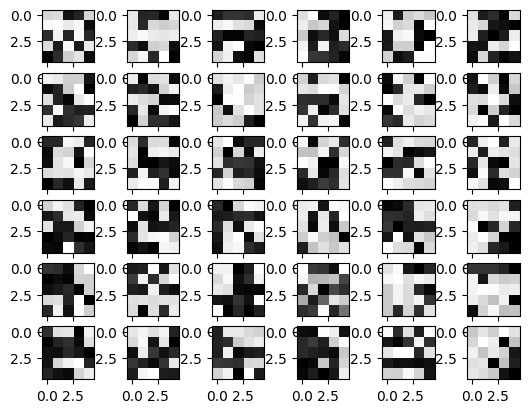

In [20]:
visualize_weight()

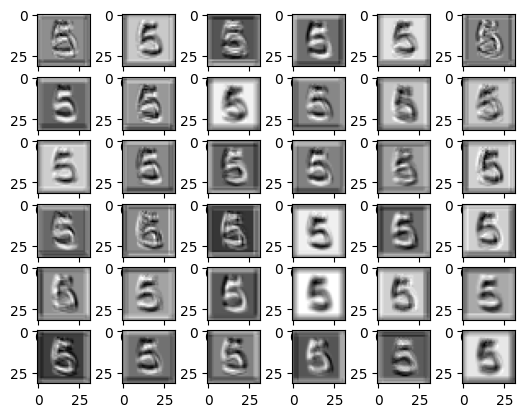

In [21]:
visualize_conv()

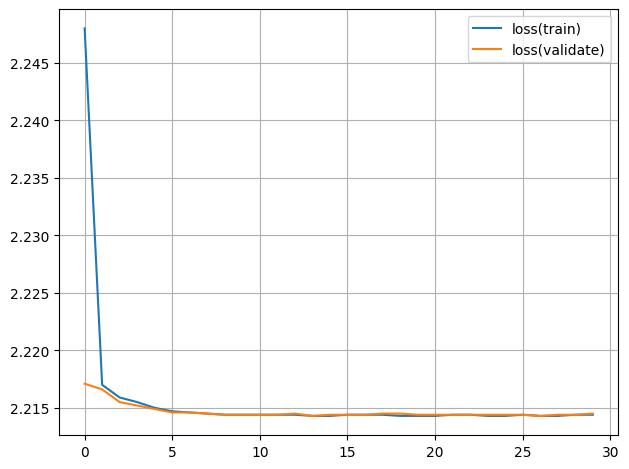

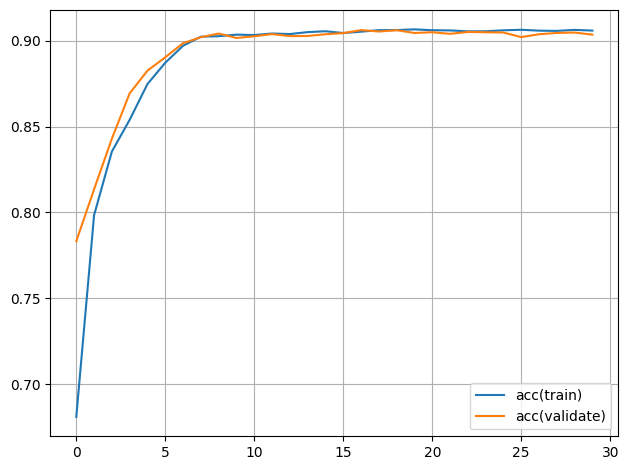

In [46]:
t_losses = history['train_loss_values']
t_accus = history['train_accuracy_values']
v_losses = history['val_loss_values']
v_accus = history['val_accuracy_values']
rng = len(t_losses)
plot_graph(t_losses, v_losses, rng, 'loss(train)','loss(validate)', 'loss.jpg')
plot_graph(t_accus, v_accus, rng, 'acc(train)', 'acc(validate)', 'acc.jpg')


test_loss:2.214417817592621,test_acc:0.916
f1_score: 0.9150832502044108


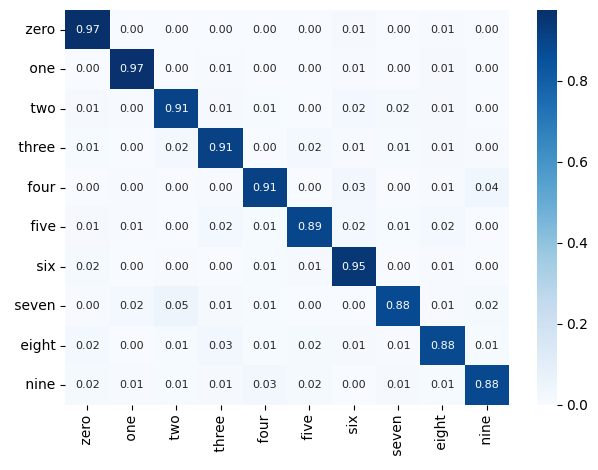

In [47]:
y_true = []
y_pred = []
test_model(model_ft, optimizer)
cm = confusion_matrix(y_true,y_pred,normalize='true')
df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index=[i for i in class_names],columns=[i for i in class_names])
plt.figure()
sns.heatmap(cm,annot=True, cmap='Blues',xticklabels=[i[3:] for i in class_names], yticklabels=[i[3:] for i in class_names],annot_kws={"size":8},fmt='.2f')

plt.tight_layout()
print('f1_score:', f1_score(y_true, y_pred,average='macro'))

#SimpleCNN_AddDrop lr=0.01

In [24]:
net = SimpleCNN_AddDrop()

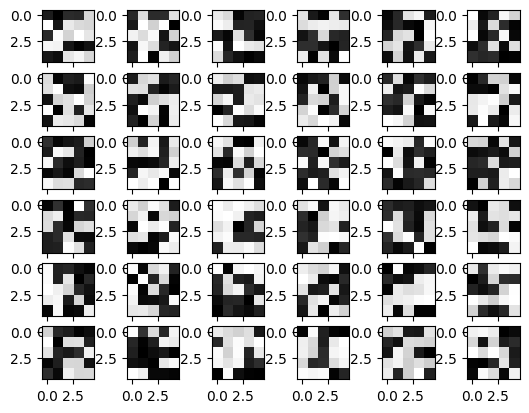

In [25]:
visualize_weight()

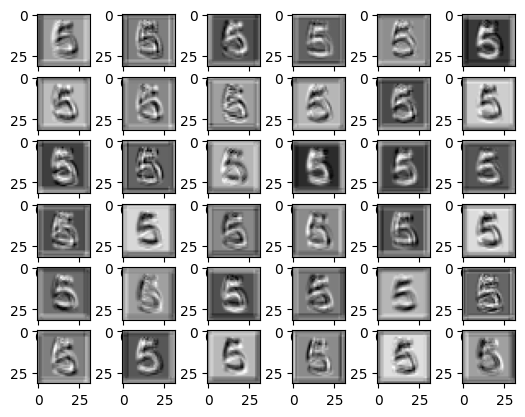

In [26]:
visualize_conv()

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.99)
scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [28]:
history = {
    'val_loss_values': [],
    'train_loss_values': [],
    'val_accuracy_values': [],
    'train_accuracy_values': []
}

model_ft, history = train_model(net, criterion, optimizer, scheduler, num_epochs=30)

Epoch 0/29
----------


[Epoch 0/29]: 100%|██████████| 480/480 [00:40<00:00, 11.85it/s]


train Loss: 2.2495 Acc: 0.6474


[Epoch 0/29]: 100%|██████████| 120/120 [00:05<00:00, 23.83it/s]


val Loss: 2.2174 Acc: 0.7647

Epoch 1/29
----------


[Epoch 1/29]: 100%|██████████| 480/480 [00:42<00:00, 11.42it/s]


train Loss: 2.2171 Acc: 0.7793


[Epoch 1/29]: 100%|██████████| 120/120 [00:05<00:00, 22.84it/s]


val Loss: 2.2164 Acc: 0.8077

Epoch 2/29
----------


[Epoch 2/29]: 100%|██████████| 480/480 [00:42<00:00, 11.32it/s]


train Loss: 2.2164 Acc: 0.8152


[Epoch 2/29]: 100%|██████████| 120/120 [00:05<00:00, 22.35it/s]


val Loss: 2.2159 Acc: 0.8311

Epoch 3/29
----------


[Epoch 3/29]: 100%|██████████| 480/480 [00:41<00:00, 11.53it/s]


train Loss: 2.2157 Acc: 0.8395


[Epoch 3/29]: 100%|██████████| 120/120 [00:05<00:00, 20.08it/s]


val Loss: 2.2153 Acc: 0.8607

Epoch 4/29
----------


[Epoch 4/29]: 100%|██████████| 480/480 [00:41<00:00, 11.55it/s]


train Loss: 2.2152 Acc: 0.8614


[Epoch 4/29]: 100%|██████████| 120/120 [00:05<00:00, 20.42it/s]


val Loss: 2.2149 Acc: 0.8768

Epoch 5/29
----------


[Epoch 5/29]: 100%|██████████| 480/480 [00:41<00:00, 11.52it/s]


train Loss: 2.2150 Acc: 0.8760


[Epoch 5/29]: 100%|██████████| 120/120 [00:05<00:00, 22.80it/s]


val Loss: 2.2147 Acc: 0.8853

Epoch 6/29
----------


[Epoch 6/29]: 100%|██████████| 480/480 [00:42<00:00, 11.33it/s]


train Loss: 2.2148 Acc: 0.8834


[Epoch 6/29]: 100%|██████████| 120/120 [00:05<00:00, 23.00it/s]


val Loss: 2.2146 Acc: 0.8909

Epoch 7/29
----------


[Epoch 7/29]: 100%|██████████| 480/480 [00:42<00:00, 11.29it/s]


train Loss: 2.2148 Acc: 0.8895


[Epoch 7/29]: 100%|██████████| 120/120 [00:05<00:00, 23.03it/s]


val Loss: 2.2145 Acc: 0.8925

Epoch 8/29
----------


[Epoch 8/29]: 100%|██████████| 480/480 [00:41<00:00, 11.63it/s]


train Loss: 2.2147 Acc: 0.8900


[Epoch 8/29]: 100%|██████████| 120/120 [00:05<00:00, 20.16it/s]


val Loss: 2.2145 Acc: 0.8961

Epoch 9/29
----------


[Epoch 9/29]: 100%|██████████| 480/480 [00:41<00:00, 11.46it/s]


train Loss: 2.2148 Acc: 0.8900


[Epoch 9/29]: 100%|██████████| 120/120 [00:05<00:00, 20.27it/s]


val Loss: 2.2145 Acc: 0.8950

Epoch 10/29
----------


[Epoch 10/29]: 100%|██████████| 480/480 [00:51<00:00,  9.25it/s]


train Loss: 2.2146 Acc: 0.8920


[Epoch 10/29]: 100%|██████████| 120/120 [00:05<00:00, 23.09it/s]


val Loss: 2.2146 Acc: 0.8969

Epoch 11/29
----------


[Epoch 11/29]: 100%|██████████| 480/480 [00:42<00:00, 11.42it/s]


train Loss: 2.2146 Acc: 0.8932


[Epoch 11/29]: 100%|██████████| 120/120 [00:05<00:00, 21.86it/s]


val Loss: 2.2146 Acc: 0.8978

Epoch 12/29
----------


[Epoch 12/29]: 100%|██████████| 480/480 [00:43<00:00, 11.06it/s]


train Loss: 2.2146 Acc: 0.8940


[Epoch 12/29]: 100%|██████████| 120/120 [00:05<00:00, 20.56it/s]


val Loss: 2.2145 Acc: 0.8988

Epoch 13/29
----------


[Epoch 13/29]: 100%|██████████| 480/480 [00:41<00:00, 11.64it/s]


train Loss: 2.2146 Acc: 0.8949


[Epoch 13/29]: 100%|██████████| 120/120 [00:05<00:00, 20.27it/s]


val Loss: 2.2145 Acc: 0.8998

Epoch 14/29
----------


[Epoch 14/29]: 100%|██████████| 480/480 [00:42<00:00, 11.40it/s]


train Loss: 2.2146 Acc: 0.8952


[Epoch 14/29]: 100%|██████████| 120/120 [00:05<00:00, 21.00it/s]


val Loss: 2.2145 Acc: 0.9002

Epoch 15/29
----------


[Epoch 15/29]: 100%|██████████| 480/480 [00:41<00:00, 11.47it/s]


train Loss: 2.2146 Acc: 0.8958


[Epoch 15/29]: 100%|██████████| 120/120 [00:05<00:00, 22.89it/s]


val Loss: 2.2145 Acc: 0.8989

Epoch 16/29
----------


[Epoch 16/29]: 100%|██████████| 480/480 [00:42<00:00, 11.29it/s]


train Loss: 2.2146 Acc: 0.8942


[Epoch 16/29]: 100%|██████████| 120/120 [00:05<00:00, 22.71it/s]


val Loss: 2.2145 Acc: 0.8984

Epoch 17/29
----------


[Epoch 17/29]: 100%|██████████| 480/480 [00:42<00:00, 11.39it/s]


train Loss: 2.2146 Acc: 0.8955


[Epoch 17/29]: 100%|██████████| 120/120 [00:05<00:00, 21.60it/s]


val Loss: 2.2145 Acc: 0.8993

Epoch 18/29
----------


[Epoch 18/29]: 100%|██████████| 480/480 [00:41<00:00, 11.53it/s]


train Loss: 2.2146 Acc: 0.8962


[Epoch 18/29]: 100%|██████████| 120/120 [00:05<00:00, 20.32it/s]


val Loss: 2.2145 Acc: 0.9008

Epoch 19/29
----------


[Epoch 19/29]: 100%|██████████| 480/480 [00:41<00:00, 11.43it/s]


train Loss: 2.2146 Acc: 0.8962


[Epoch 19/29]: 100%|██████████| 120/120 [00:05<00:00, 20.08it/s]


val Loss: 2.2145 Acc: 0.8999

Epoch 20/29
----------


[Epoch 20/29]: 100%|██████████| 480/480 [00:42<00:00, 11.41it/s]


train Loss: 2.2146 Acc: 0.8947


[Epoch 20/29]: 100%|██████████| 120/120 [00:05<00:00, 22.53it/s]


val Loss: 2.2145 Acc: 0.9005

Epoch 21/29
----------


[Epoch 21/29]: 100%|██████████| 480/480 [00:43<00:00, 11.14it/s]


train Loss: 2.2146 Acc: 0.8966


[Epoch 21/29]: 100%|██████████| 120/120 [00:05<00:00, 23.21it/s]


val Loss: 2.2144 Acc: 0.9000

Epoch 22/29
----------


[Epoch 22/29]: 100%|██████████| 480/480 [00:43<00:00, 11.13it/s]


train Loss: 2.2146 Acc: 0.8950


[Epoch 22/29]: 100%|██████████| 120/120 [00:05<00:00, 23.12it/s]


val Loss: 2.2145 Acc: 0.8993

Epoch 23/29
----------


[Epoch 23/29]: 100%|██████████| 480/480 [00:42<00:00, 11.30it/s]


train Loss: 2.2146 Acc: 0.8964


[Epoch 23/29]: 100%|██████████| 120/120 [00:05<00:00, 21.56it/s]


val Loss: 2.2145 Acc: 0.9004

Epoch 24/29
----------


[Epoch 24/29]: 100%|██████████| 480/480 [00:42<00:00, 11.41it/s]


train Loss: 2.2146 Acc: 0.8963


[Epoch 24/29]: 100%|██████████| 120/120 [00:05<00:00, 20.08it/s]


val Loss: 2.2145 Acc: 0.9003

Epoch 25/29
----------


[Epoch 25/29]: 100%|██████████| 480/480 [00:42<00:00, 11.37it/s]


train Loss: 2.2146 Acc: 0.8969


[Epoch 25/29]: 100%|██████████| 120/120 [00:05<00:00, 20.14it/s]


val Loss: 2.2145 Acc: 0.9005

Epoch 26/29
----------


[Epoch 26/29]: 100%|██████████| 480/480 [00:42<00:00, 11.27it/s]


train Loss: 2.2146 Acc: 0.8961


[Epoch 26/29]: 100%|██████████| 120/120 [00:06<00:00, 19.89it/s]


val Loss: 2.2145 Acc: 0.8972

Epoch 27/29
----------


[Epoch 27/29]: 100%|██████████| 480/480 [00:42<00:00, 11.39it/s]


train Loss: 2.2146 Acc: 0.8956


[Epoch 27/29]: 100%|██████████| 120/120 [00:05<00:00, 23.12it/s]


val Loss: 2.2145 Acc: 0.8992

Epoch 28/29
----------


[Epoch 28/29]: 100%|██████████| 480/480 [00:43<00:00, 11.13it/s]


train Loss: 2.2146 Acc: 0.8968


[Epoch 28/29]: 100%|██████████| 120/120 [00:05<00:00, 22.28it/s]


val Loss: 2.2146 Acc: 0.8990

Epoch 29/29
----------


[Epoch 29/29]: 100%|██████████| 480/480 [00:43<00:00, 11.16it/s]


train Loss: 2.2146 Acc: 0.8963


[Epoch 29/29]: 100%|██████████| 120/120 [00:05<00:00, 22.70it/s]

val Loss: 2.2146 Acc: 0.9002

Training complete in 24m 1s
Best val Acc: 0.900833


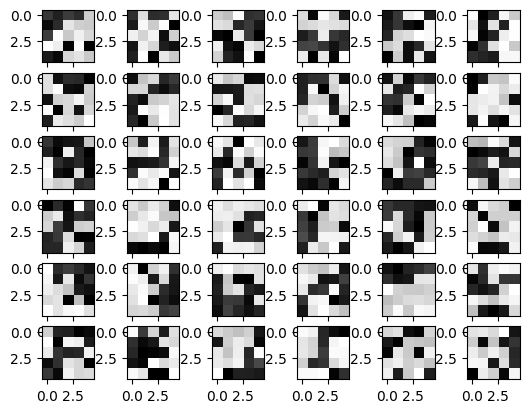

In [29]:
visualize_weight()

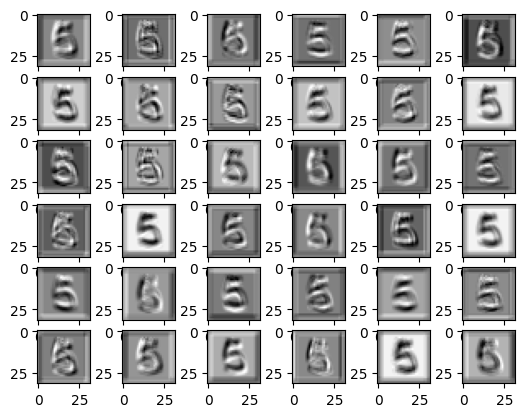

In [30]:
visualize_conv()

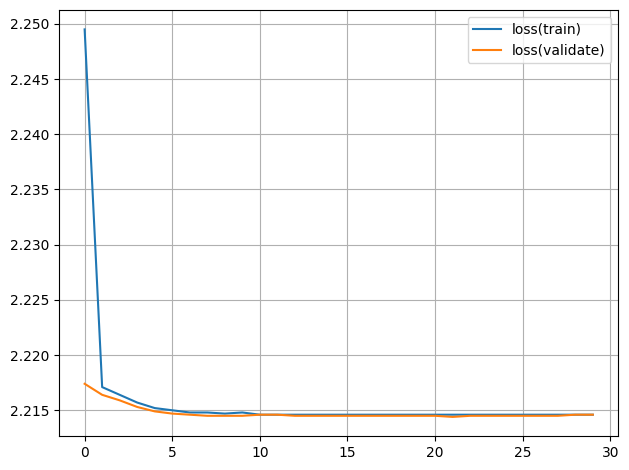

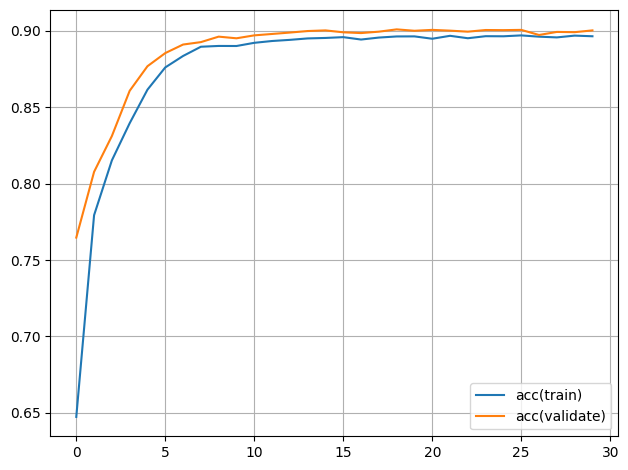

In [31]:
t_losses = history['train_loss_values']
t_accus = history['train_accuracy_values']
v_losses = history['val_loss_values']
v_accus = history['val_accuracy_values']
rng = len(t_losses)
plot_graph(t_losses, v_losses, rng, 'loss(train)','loss(validate)', 'loss.jpg')
plot_graph(t_accus, v_accus, rng, 'acc(train)', 'acc(validate)', 'acc.jpg')


test_loss:2.2145142126083375,test_acc:0.9115
f1_score: 0.9105710281922368


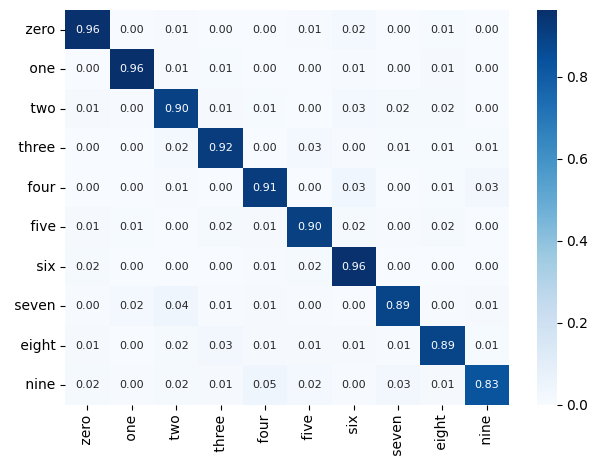

In [32]:
y_true = []
y_pred = []
test_model(model_ft, optimizer)
cm = confusion_matrix(y_true,y_pred,normalize='true')
df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index=[i for i in class_names],columns=[i for i in class_names])
plt.figure()
sns.heatmap(cm,annot=True, cmap='Blues',xticklabels=[i[3:] for i in class_names], yticklabels=[i[3:] for i in class_names],annot_kws={"size":8},fmt='.2f')

plt.tight_layout()
print('f1_score:', f1_score(y_true, y_pred,average='macro'))